In [1]:
%load_ext autoreload
%autoreload 2

In [101]:
import sys
import uuid
import logging
import getpass
import cv2
import os
import gc
import time
import imageio
import random
import copy
import glob
import json
import zipfile
import shutil
import pickle
import traceback
import xml.etree.ElementTree as ET
from collections import Counter
from pprint import pprint as print

In [86]:
from tqdm import tqdm, tqdm_notebook
import requests

import matplotlib.pyplot as plt
import numpy as np

In [4]:
from test_api import CLI, CVAT_API_V1, ResourceType

In [163]:
def imshow(img, figsize=(16, 16)):
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.axis('off')
    ax.imshow(img)

In [5]:
class Args:
    
    def __init__(self, action="create"):
        
        self.action = action
        self.auth = ("", "")  # type tuple
        self.server_host = ""
        self.server_port = 8080
        self.https = False
        self.loglevel = 20

        self.name = "test_1504"
        self.labels = [{"name":"text", "attributes": []}]  # type list
        self.overlap = 0
        self.segment_size = 0
        self.bug = ""
        self.resource_type = ResourceType(0)
        self.resources = ["/home/phan.huy.hoang/Pictures/test_img_cvat.zip"]
        self.annotation_path = "/home/phan.huy.hoang/cvat/utils/cli/instances_default.json"
        self.annotation_format = "COCO 1.0"

        # for git only
        self.completion_verification_period = 10
        self.dataset_repository_url = ""
        self.lfs = False

args = Args()

In [ ]:
CVAT_URL = "http://{}:{}/".format(args.server_host, args.server_port)
API_URL = CVAT_URL + "api/v1/"
username, password = args.auth
username, password

In [7]:
def get_cookies():
    login_json = {"username": username, "password": password}
    login_req = requests.post(API_URL + 'auth/login', json=login_json)
    cookies = login_req.cookies
    return cookies

cookies = get_cookies()

In [ ]:
req = requests.get("{}/api/v1/tasks/660".format(CVAT_URL), cookies=cookies)
req.text

### List all available tasks

- task id line segmentation (Linh, Huyen, Nhi): 592 -> 648

In [269]:
# with requests.Session() as session:
#     api = CVAT_API_V1('{}:{}'.format(args.server_host, args.server_port), args.https)
#     cli = CLI(session, api, args.auth)
    
# res = cli.tasks_list(use_json_output=True)
# print(len(res))

In [271]:
task_ids = range(592, 649)
print(len(task_ids))

57


### Download annotated data for each task (only annotation files) - skip this part

download API

In [ ]:
# task_id = task_ids[0]

In [ ]:
# >>>>>>>> CHANGE this variable to save all the downloaded image and annotation files!
# saved_dir = "./dump/annotated_data/stamp_table"

In [ ]:
# download as zip file
# res = cli.tasks_dump(task_id, "COCO 1.0", os.path.join(saved_dir, "{}.zip".format(task_id)))

In [ ]:
# file will save in the folder: $saved_dir/530.zip
# for task_id in tqdm_notebook(task_ids):
#     cli.tasks_dump(task_id, "COCO 1.0", os.path.join(saved_dir, "{}.zip".format(task_id)))

### Download both image + annotation

export API

- line segment (Nhi, Huyen, Linh): 592 -> 648

In [272]:
# >>>>>>>> CHANGE root folder to save all the downloaded image and annotation files!
saved_dir = "/media/SUN-ASTERISK\phan.huy.hoang/My Passport/phanhoang/data/PDF_converter/CVAT_server/line_annotated/raw"
assert os.path.exists(saved_dir)

In [273]:
# >>> only download annotation file
# url_fmt = "http://{}:8080/api/v1/tasks/{}/annotations?format=CVAT%20for%20images%201.1&filename=test123&action=download"

# >>> download both image + annotation
url_fmt = "http://{}:8080/api/v1/tasks/{}/dataset?format=CVAT%20for%20images%201.1&action=download"

In [274]:
def download_file(req, task_id):
    with open(os.path.join(saved_dir, '{}.zip'.format(task_id)), 'wb') as f:
        for chunk in req.iter_content(chunk_size=1024): 
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
    print("Task {} download completed".format(task_id))

In [275]:
task_ids = range(592, 649)  # list all availabel task ids HERE
print(len(task_ids))

57


In [276]:
# download all data (image + annotation)
for task_id in tqdm_notebook(task_ids):
    url = url_fmt.format(args.server_host, task_id)
    
    while True:
        req = requests.get(url, cookies=cookies)
        if req.status_code == 200:
            download_file(req, task_id)
            break
            
        time.sleep(5)

'Task 592 download completed'
'Task 593 download completed'
'Task 594 download completed'
'Task 595 download completed'
'Task 596 download completed'
'Task 597 download completed'
'Task 598 download completed'
'Task 599 download completed'
'Task 600 download completed'
'Task 601 download completed'
'Task 602 download completed'
'Task 603 download completed'
'Task 604 download completed'
'Task 605 download completed'
'Task 606 download completed'
'Task 607 download completed'
'Task 608 download completed'
'Task 609 download completed'
'Task 610 download completed'
'Task 611 download completed'
'Task 612 download completed'
'Task 613 download completed'
'Task 614 download completed'
'Task 615 download completed'
'Task 616 download completed'
'Task 617 download completed'
'Task 618 download completed'
'Task 619 download completed'
'Task 620 download completed'
'Task 621 download completed'
'Task 622 download completed'
'Task 623 download completed'
'Task 624 download completed'
'Task 625 

### unzip folder

In [ ]:
len(task_ids)

In [277]:
# unzip all zip files in the same root folder
for task_id in task_ids:
    zip_fp = os.path.join(saved_dir, "{}.zip".format(task_id))
    assert os.path.exists(zip_fp)
    
    task_dir = os.path.join(saved_dir, str(task_id))
    if not os.path.exists(task_dir):
        os.mkdir(task_dir)
        
    with zipfile.ZipFile(zip_fp, "r") as zip_ref:
        zip_ref.extractall(task_dir)

### Preprocess annotated data for line-segmentation model

1 task ~ 100 files

tree folder: 592 is task's id
```bash
.
├── 592
│   ├── annotations.xml
│   └── images
├── 592.zip
├── 593
│   ├── annotations.xml
│   └── images
└── 593.zip
...
```

In [ ]:
# task_id = task_ids[0]
# img_dir = os.path.join(saved_dir, str(task_id), "images")
# anno_fp = os.path.join(saved_dir, str(task_id), "annotations.xml")
# assert os.path.exists(img_dir)
# assert os.path.exists(anno_fp)

# img_fps = sorted(glob.glob(os.path.join(img_dir, "*.png")))
# print(len(img_fps))

In [361]:
task_ids = range(592, 649)
# task_ids = [593]

In [368]:
task_mapping = {}
for task_id in tqdm_notebook(task_ids):
    img_dir = os.path.join(saved_dir, str(task_id), "images")
    anno_fp = os.path.join(saved_dir, str(task_id), "annotations.xml")
    assert os.path.exists(img_dir)
    assert os.path.exists(anno_fp)

    # for 1 task
    tree = ET.parse(anno_fp)
    root = tree.getroot()

    mapping = {}
    for elem in root:
        img_fn = elem.attrib.get("name", None)
        if img_fn is None:
            continue
        lines = []
        if elem.tag == "image":
            for subelem in elem:
                polyline = subelem.attrib.get("points", None)
                if polyline is None:
                    continue

                xys = polyline.split(";")
                xys = [map(float, xy.split(",")) for xy in xys]
                xys = [list(map(round, xy)) for xy in xys]
                lines.append(xys)

        mapping[img_fn] = lines
    task_mapping[task_id] = mapping

In [371]:
task_id = random.choice(task_ids)
img_dir = os.path.join(saved_dir, str(task_id), "images")
img_fps = sorted(glob.glob(os.path.join(img_dir, "*.png")))
print(len(img_fps))

100


56
(602, 967, 3)


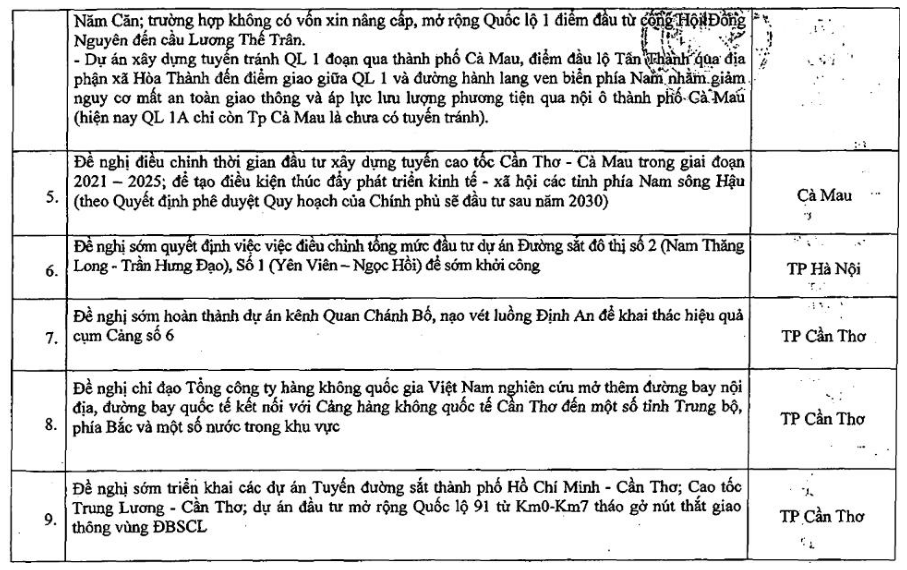

In [385]:
# 100 files per task
random_id = random.choice(range(len(img_fps))
print(random_id)

img_fp = img_fps[random_id]
img_fn = img_fp.split("/")[-1]
mapping = task_mapping[task_id]
annos = mapping[img_fn]
img = cv2.imread(os.path.join(img_dir, img_fn))[:, :, ::-1]
print(img.shape)
imshow(img)

### visualize polylines

In [386]:
# skip this file
if len(annos) == 0:
    raise NotImplementedError("File does not contain any annotation")

array([  0., 255.])


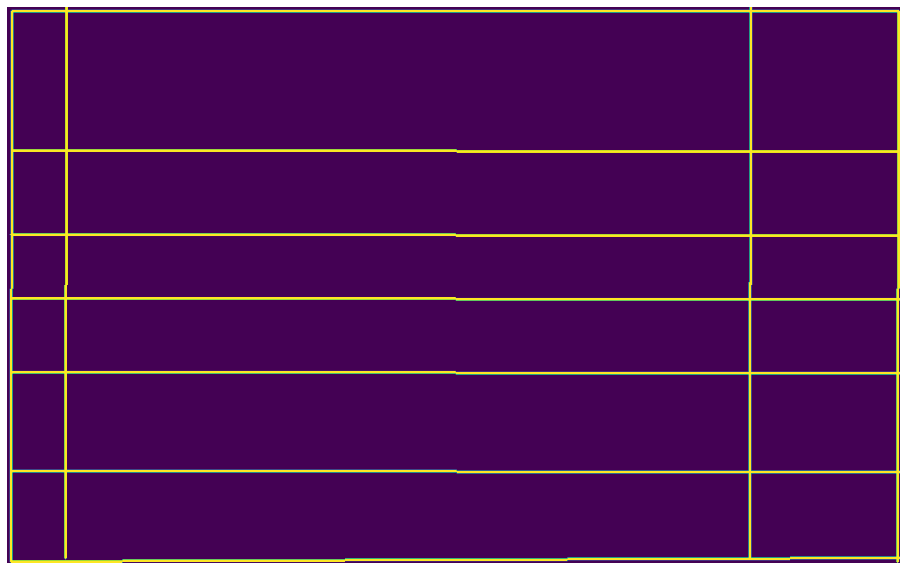

In [387]:
# vis_img = img.copy()
h, w, c = img.shape
vis_img = np.zeros((h, w))
for anno in annos:
    polys = copy.deepcopy(anno)
    
    # some obj have more 2 points
    if len(polys) > 2:
        for poly in list(zip(polys, polys[1:])):
            poly = np.array(poly).astype(np.int32)
            cv2.polylines(vis_img, [poly], True, (255, 255, 255), thickness=2)
    else:
        polys = np.array(polys).astype(np.int32)
        cv2.polylines(vis_img, [polys], True, (255, 255, 255), thickness=2)

print(np.unique(vis_img))
imshow(vis_img)
# imageio.imwrite("./dump/foo.png", vis_img.astype(np.uint8))

In [389]:
# kernel = np.ones((3, 3), np.uint8) 
# img2 = cv2.dilate(vis_img, kernel, iterations=3)
# img2 = cv2.erode(img2, kernel, iterations=3)
# imshow(img2)